In [10]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pickle
import os
import json
from sklearn.metrics import roc_curve, auc

In [2]:
with open('event_total.json', 'r') as f:
    event_totals = json.load(f)

In [3]:
path = '/project01/ndcms/cmoore24/skims/full_cut_skims/sole_vars/'

In [4]:
qcd = {}
files = os.listdir(f'{path}')
for i in files:
    if 'qcd' in i:
        qcd[i.rstrip('.parquet')] = ak.firsts(ak.from_parquet(f'{path}/{i}'))

In [6]:
IL = 44.99
xsec = {}
xsec['qcd_300to470'] = 6833
xsec['qcd_470to600'] = 549.5
xsec['qcd_600to800'] = 156.5
xsec['qcd_800to1000'] = 26.22
xsec['qcd_1000to1400'] = 7.475
xsec['qcd_1400to1800'] = 0.6482
xsec['qcd_1800to2400'] = 0.08742
xsec['qcd_2400to3200'] = 0.005237
xsec['qcd_3200toInf'] = 0.0001353

In [7]:
qcd_sf_dict = {}
for i in qcd:
    et_name = i.strip('qcd_')
    qcd_sf_dict[i] = (((xsec[i]*1000)*IL)/(event_totals['qcd'][f'{et_name}']))

In [8]:
def nan_remover(sample):
    if type(sample) == dict:
        for j in sample:
            mask = ak.ones_like(sample[j][sample[j].fields[0]], dtype='bool')
            mask = ak.fill_none(mask, True)
            for k in sample[j].fields:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
            sample[j] = sample[j][mask]
    else:
        mask = ak.ones_like(sample[sample.fields[0]], dtype='bool')
        mask = ak.fill_none(mask, True)
        for j in sample.fields:
            mask = mask & (~ak.is_none(ak.nan_to_none(sample[j])))
        sample = sample[mask]
    return sample

In [9]:
qcd = nan_remover(qcd)

In [80]:
del(qcd['qcd_300to470'])

In [81]:
qcd_stitched_dict = {}
qcd_frac = {}
for i in qcd:
    qcd_frac[i] = ((xsec[i]*1000)*IL)/len(qcd[i])
qcd_frac['tot'] = sum(qcd_frac.values())
sval = {}
for i in qcd:
    sval[i] = qcd_frac[i]/qcd_frac['tot']
combed = {}
for i in qcd:
    temp = qcd[i]
    combed[i] = temp[np.random.rand(len(temp)) < sval[i]]
qcd_stitched_dict = ak.concatenate([combed[x] for x in combed])

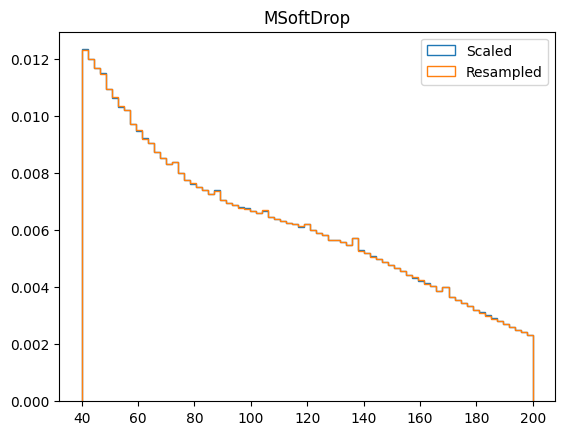

In [82]:
plt.hist(
    ak.concatenate([qcd[i].msoftdrop for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].mass) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['msoftdrop'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled')

plt.legend()
plt.title('MSoftDrop')
plt.show()

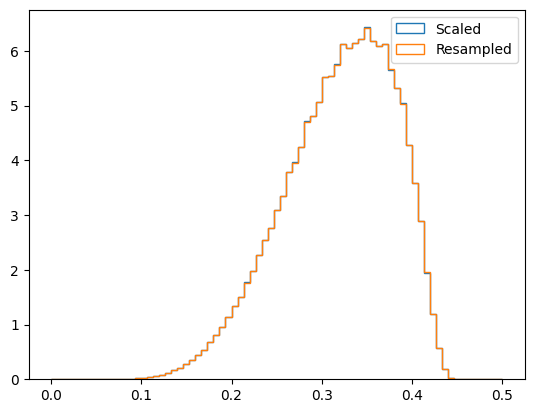

In [83]:
plt.hist(
    ak.concatenate([qcd[i].n2b1 for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].n2b1) for i in qcd]),
    range=(0,0.5),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['n2b1'], range=(0,0.5), bins=75, histtype='step', density=True, label='Resampled')
# plt.yscale('log')
plt.legend()
plt.show()

In [84]:
stitched_n2_cut = qcd_stitched_dict[qcd_stitched_dict.n2b1 < 0.35]
n2_individual_cut = {}
for i in qcd:
    n2_individual_cut[i] = qcd[i][qcd[i].n2b1 < 0.35]

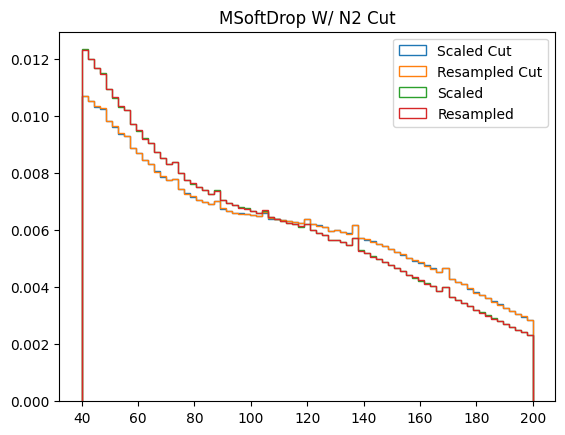

In [85]:
plt.hist(
    ak.concatenate([n2_individual_cut[i].msoftdrop for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(n2_individual_cut[i].msoftdrop) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='Scaled Cut'
)
plt.hist(stitched_n2_cut['msoftdrop'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled Cut')

plt.hist(
    ak.concatenate([qcd[i].msoftdrop for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].msoftdrop) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['msoftdrop'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled')

plt.legend()
plt.title('MSoftDrop W/ N2 Cut')
plt.show()

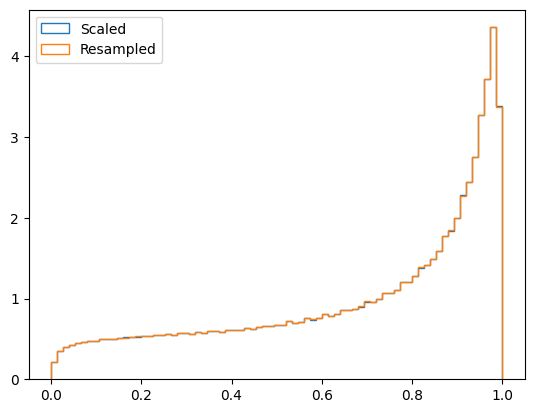

In [86]:
plt.hist(
    ak.concatenate([qcd[i].particleNetMD_QCD for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].particleNetMD_QCD) for i in qcd]),
    range=(0,1),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['particleNetMD_QCD'], range=(0,1), bins=75, histtype='step', density=True, label='Resampled')
# plt.yscale('log')
plt.legend()
plt.show()

In [87]:
stitched_pn_cut = qcd_stitched_dict[qcd_stitched_dict.particleNetMD_QCD < 0.1]
pn_individual_cut = {}
for i in qcd:
    pn_individual_cut[i] = qcd[i][qcd[i].particleNetMD_QCD < 0.1]

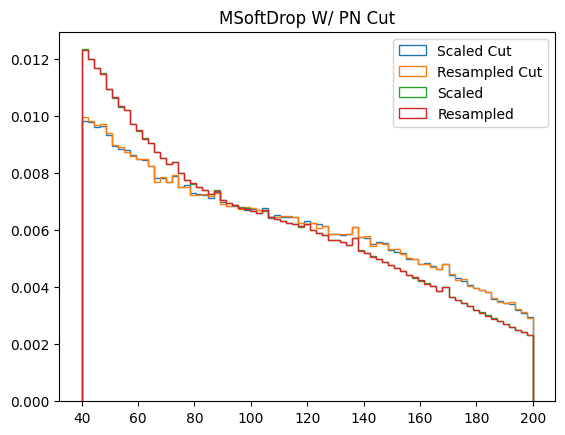

In [88]:
plt.hist(
    ak.concatenate([pn_individual_cut[i].msoftdrop for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(pn_individual_cut[i].mass) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='Scaled Cut'
)
plt.hist(stitched_pn_cut['msoftdrop'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled Cut')

plt.hist(
    ak.concatenate([qcd[i].msoftdrop for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].mass) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['msoftdrop'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled')

plt.legend()
plt.title('MSoftDrop W/ PN Cut')
plt.show()

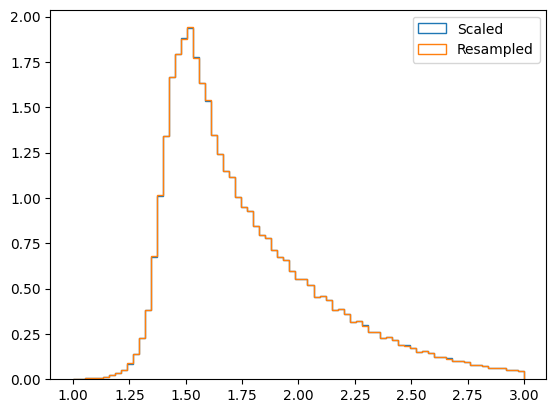

In [90]:
plt.hist(
    ak.concatenate([qcd[i].n3b1 for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].n3b1) for i in qcd]),
    range=(1,3),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['n3b1'], range=(1,3), bins=75, histtype='step', density=True, label='Resampled')
# plt.yscale('log')
plt.legend()
plt.show()

In [91]:
stitched_n3_cut = qcd_stitched_dict[qcd_stitched_dict.n3b1 > 1.7]
n3_individual_cut = {}
for i in qcd:
    n3_individual_cut[i] = qcd[i][qcd[i].n3b1 > 1.7]

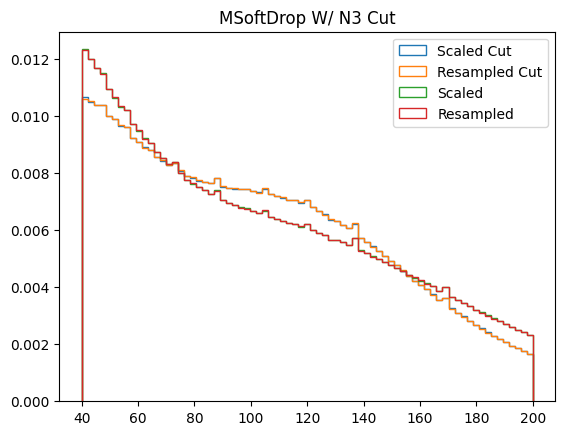

In [92]:
plt.hist(
    ak.concatenate([n3_individual_cut[i].msoftdrop for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(n3_individual_cut[i].mass) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='Scaled Cut'
)
plt.hist(stitched_n3_cut['msoftdrop'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled Cut')

plt.hist(
    ak.concatenate([qcd[i].msoftdrop for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].mass) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['msoftdrop'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled')

plt.legend()
plt.title('MSoftDrop W/ N3 Cut')
plt.show()

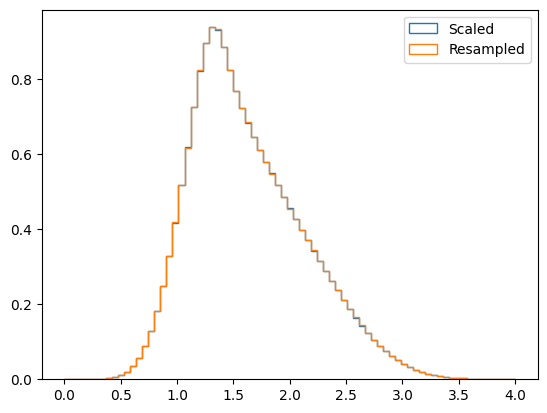

In [93]:
plt.hist(
    ak.concatenate([qcd[i].d2b1 for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].d2b1) for i in qcd]),
    range=(0,4),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['d2b1'], range=(0,4), bins=75, histtype='step', density=True, label='Resampled')
# plt.yscale('log')
plt.legend()
plt.show()

In [94]:
stitched_d2_cut = qcd_stitched_dict[qcd_stitched_dict.d2b1 > 2]
d2_individual_cut = {}
for i in qcd:
    d2_individual_cut[i] = qcd[i][qcd[i].d2b1 > 2]

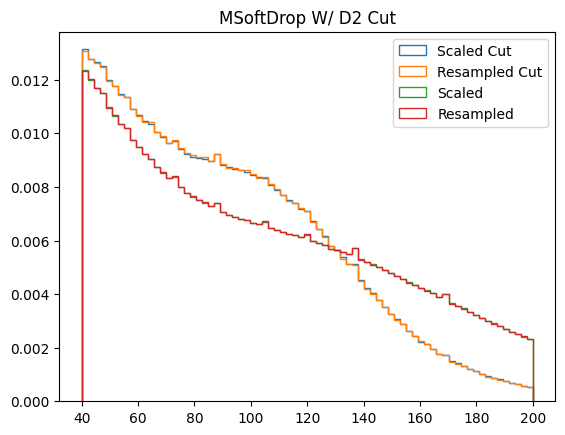

In [95]:
plt.hist(
    ak.concatenate([d2_individual_cut[i].msoftdrop for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(d2_individual_cut[i].mass) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='Scaled Cut'
)
plt.hist(stitched_d2_cut['msoftdrop'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled Cut')

plt.hist(
    ak.concatenate([qcd[i].msoftdrop for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].mass) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['msoftdrop'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled')

plt.legend()
plt.title('MSoftDrop W/ D2 Cut')
plt.show()

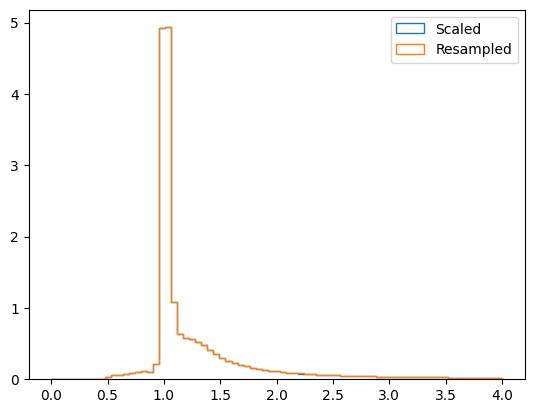

In [96]:
plt.hist(
    ak.concatenate([qcd[i].color_ring for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].color_ring) for i in qcd]),
    range=(0,4),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['color_ring'], range=(0,4), bins=75, histtype='step', density=True, label='Resampled')
# plt.yscale('log')
plt.legend()
plt.show()

In [97]:
stitched_cr_cut = qcd_stitched_dict[qcd_stitched_dict.color_ring < 1]
cr_individual_cut = {}
for i in qcd:
    cr_individual_cut[i] = qcd[i][qcd[i].color_ring < 1]

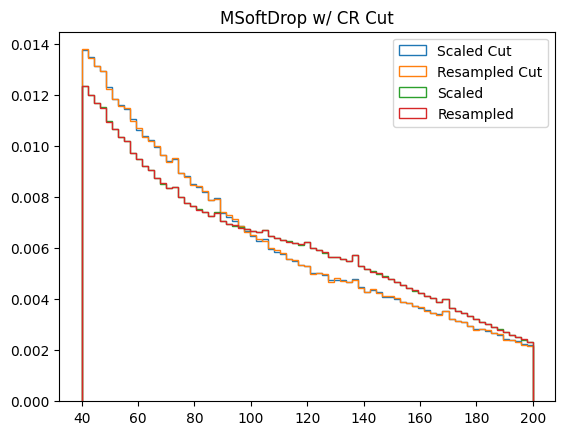

In [98]:
plt.hist(
    ak.concatenate([cr_individual_cut[i].msoftdrop for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(cr_individual_cut[i].mass) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='Scaled Cut'
)
plt.hist(stitched_cr_cut['msoftdrop'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled Cut')

plt.hist(
    ak.concatenate([qcd[i].msoftdrop for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].mass) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['msoftdrop'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled')

plt.legend()
plt.title('MSoftDrop w/ CR Cut')
plt.show()

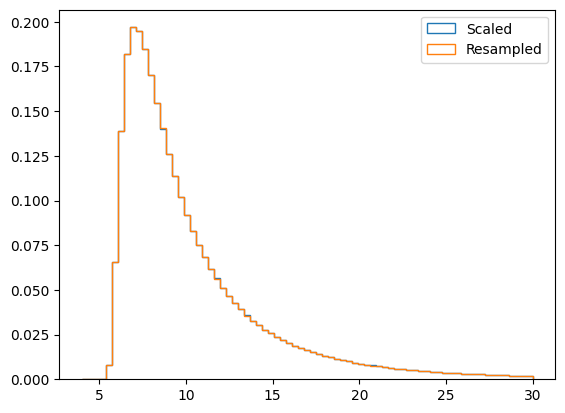

In [99]:
plt.hist(
    ak.concatenate([qcd[i].n4 for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].n4) for i in qcd]),
    range=(4,30),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['n4'], range=(4,30), bins=75, histtype='step', density=True, label='Resampled')
# plt.yscale('log')
plt.legend()
plt.show()

In [102]:
stitched_n4_cut = qcd_stitched_dict[qcd_stitched_dict.n4 > 10]
n4_individual_cut = {}
for i in qcd:
    n4_individual_cut[i] = qcd[i][qcd[i].n4 > 10]

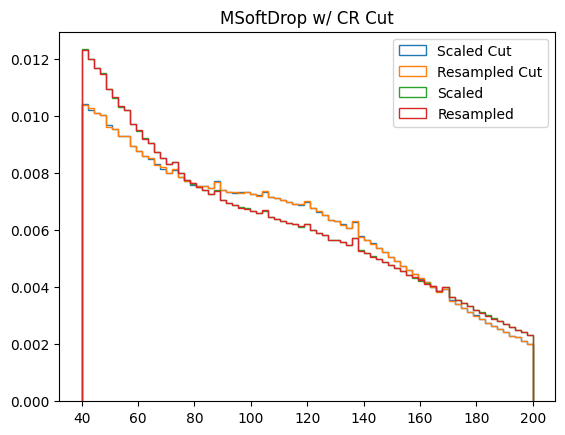

In [103]:
plt.hist(
    ak.concatenate([n4_individual_cut[i].msoftdrop for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(n4_individual_cut[i].msoftdrop) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='Scaled Cut'
)
plt.hist(stitched_n4_cut['msoftdrop'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled Cut')

plt.hist(
    ak.concatenate([qcd[i].msoftdrop for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].msoftdrop) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['msoftdrop'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled')

plt.legend()
plt.title('MSoftDrop w/ CR Cut')
plt.show()